In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
data = pd.read_csv('data/data.csv')

In [128]:
data['more_than_5_mag'] = data['mag'] > 5
data['magnitude_label'] = data['more_than_5_mag'].apply(lambda x: 'Magnitude >= 5' if x else 'Magnitude < 5')


### Correlations between cols

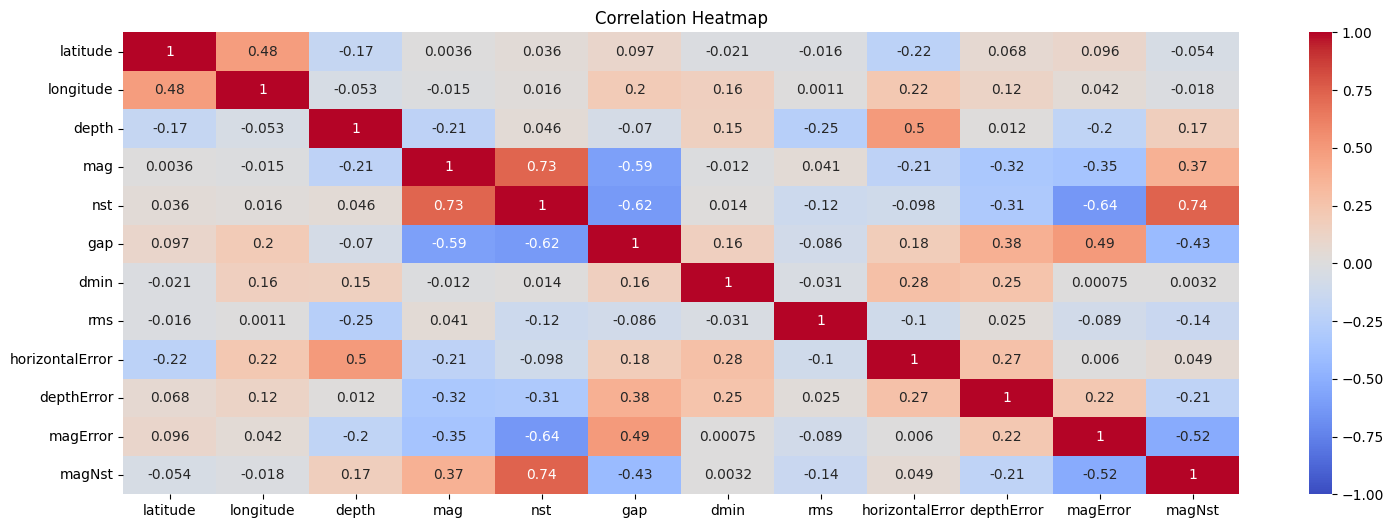

In [129]:
df_numeric = data.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Create the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

There are a few pretty high positive and negative correlations between number of stations used to determine earthquake location and several columns: magnitude (+), amount of stations that determine the magnitude (+), uncertainity of reported magnitude of the event (-), the largest azimuthal gap between azimuthally adjacent stations (-). There is also negative correlation between magnitude estimation error and the amount of calculating stations.

### Cluster the data by cordinates

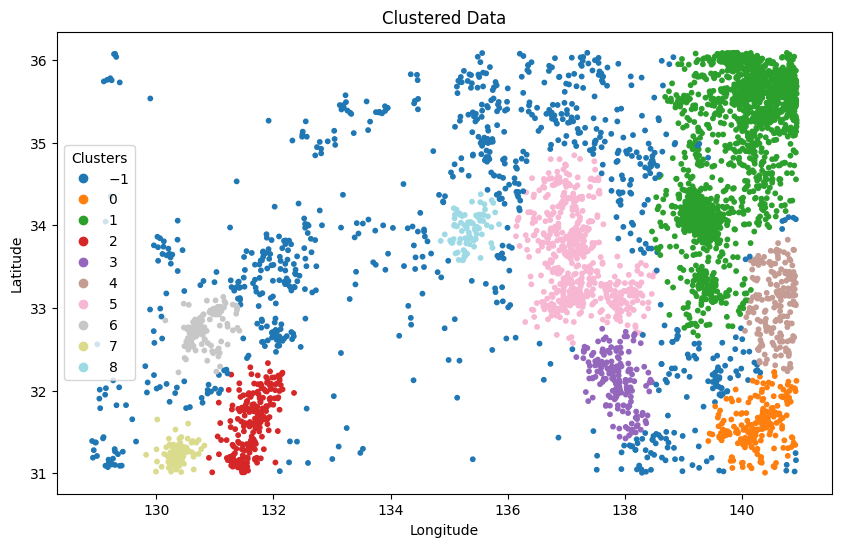

In [130]:
from sklearn.cluster import DBSCAN
coords = data[['latitude', 'longitude']].to_numpy()

coords_rad = np.radians(coords) # Convert degrees to radians

# Variables
earth_radius = 6371.0088
epsilon = 35  # in kilometers
epsilon_rad = epsilon / earth_radius
db = DBSCAN(eps=epsilon_rad, min_samples=50, algorithm='ball_tree', metric='haversine')
clusters = db.fit_predict(coords_rad)
data['cluster'] = clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['longitude'], data['latitude'], c=data['cluster'], cmap='tab20', s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustered Data')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [131]:
import folium
from folium.plugins import MarkerCluster

# Initialize a map
m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=10)

# Add clusters to the map
marker_cluster = MarkerCluster().add_to(m)
for idx, row in data.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=f"Cluster: {row['cluster']}").add_to(marker_cluster)

m

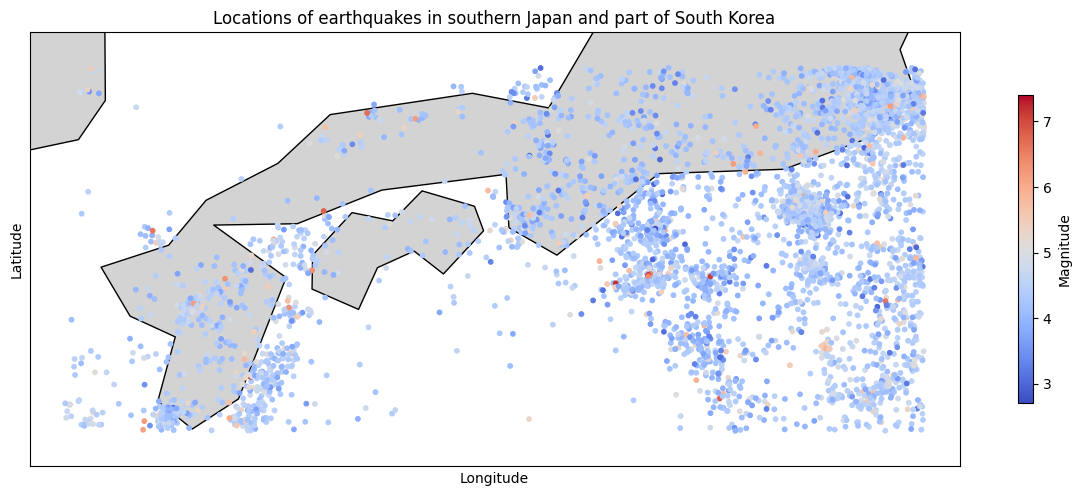

In [132]:
from shapely.geometry import box
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]

gdf = gpd.GeoDataFrame(data, geometry=geometry)

minx, miny, maxx, maxy = gdf.total_bounds

padding = 0.5  # degrees of longitude/latitude
minx -= padding
miny -= padding
maxx += padding
maxy += padding

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs(epsg=4326)  # Ensure CRS is WGS84

bbox = box(minx, miny, maxx, maxy)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs='EPSG:4326')

# Clip the world map to the bounding box
world_clipped = gpd.clip(world, geo)

fig, ax = plt.subplots(figsize=(15, 20))
world_clipped.plot(ax=ax, color='lightgray', edgecolor='black')

ax.set_xticks([])
ax.set_yticks([])

# Plot your data
gdf.plot(
        ax=ax, 
        marker='o',
        markersize=10, 
        alpha=1,     
        column='mag',  # Column to use for color mapping
        cmap='coolwarm',       # Colormap (you can choose any matplotlib colormap)
        legend=True,  # Show the legend
        legend_kwds={
            'label': "Magnitude",
            'orientation': "vertical",
                    'shrink': 0.2,      # Shrink the colorbar size
        'aspect': 20        # Aspect ratio of the colorbar
        }
    )

# Set x and y limits to focus on your data
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Locations of earthquakes in southern Japan and part of South Korea')

plt.show()

### Time trends

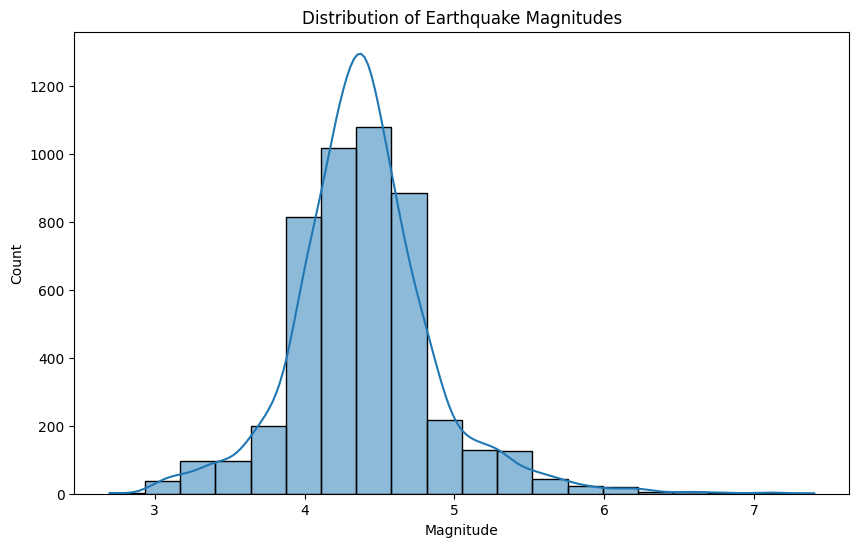

In [133]:
# plot the magnitude of the earthquakes
plt.figure(figsize=(10, 6))
sns.histplot(data['mag'], bins=20, kde=True)
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.show()

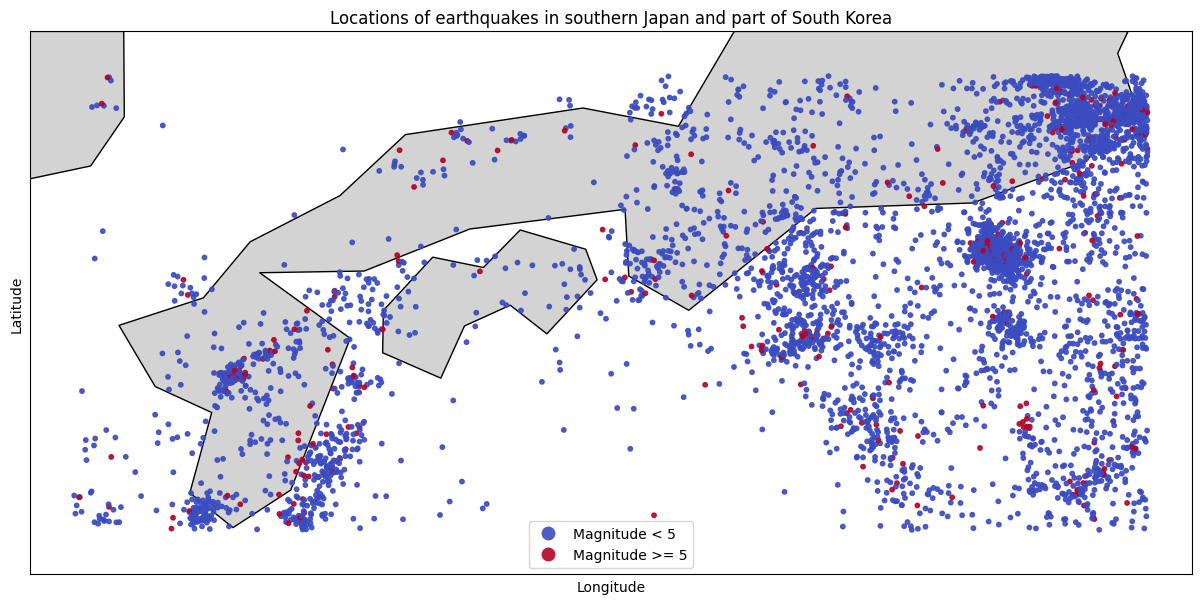

In [139]:
fig, ax = plt.subplots(figsize=(15, 20))
world_clipped.plot(ax=ax, color='lightgray', edgecolor='black')

ax.set_xticks([])
ax.set_yticks([])

# Plot your data
gdf.plot(
        ax=ax, 
        marker='o',
        markersize=10, 
        alpha=0.9,     
        column='magnitude_label',  # Column to use for color mapping
        cmap='coolwarm',       # Colormap (you can choose any matplotlib colormap)
        legend=True,  # Show the legend
    )

# Set x and y limits to focus on your data
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Locations of earthquakes in southern Japan and part of South Korea')

plt.show()

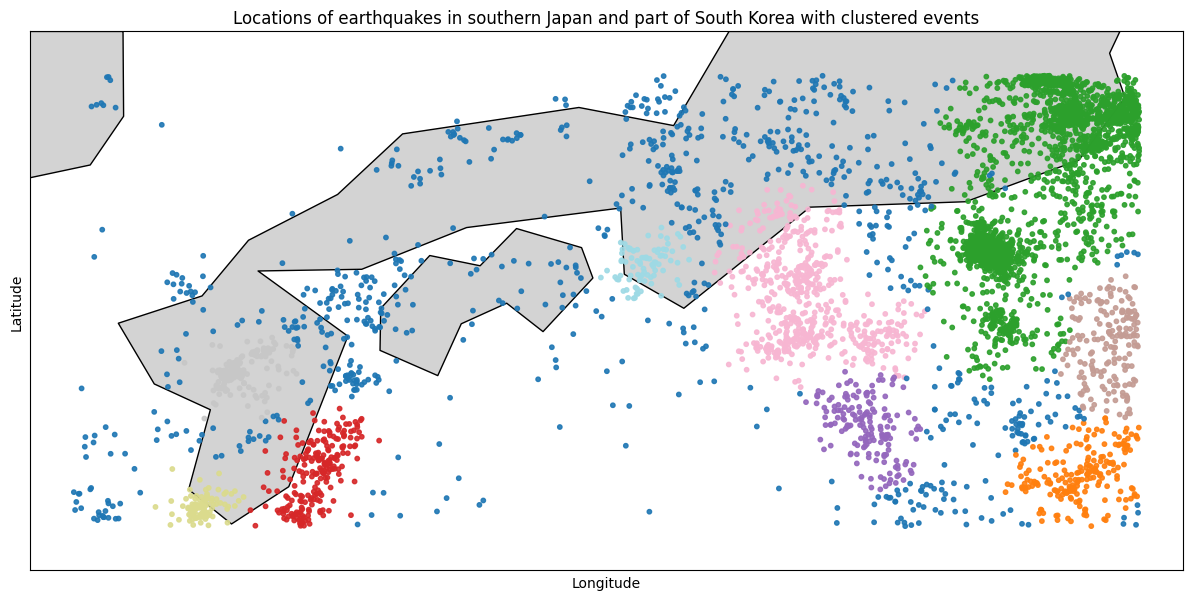

In [135]:
fig, ax = plt.subplots(figsize=(15, 7))
world_clipped.plot(ax=ax, color='lightgrey', edgecolor='black')

ax.set_xticks([])
ax.set_yticks([])

# Plot your data
gdf.plot(
        ax=ax, 
        marker='o',
        markersize=10, 
        alpha=0.9,     
        column='cluster',  # Column to use for color mapping
        cmap='tab20',       # Colormap (you can choose any matplotlib colormap)
        # legend=True,  # Show the legend
    )

# Set x and y limits to focus on your data
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Locations of earthquakes in southern Japan and part of South Korea with clustered events')

# ax.legend(fontsize='small')

plt.show()

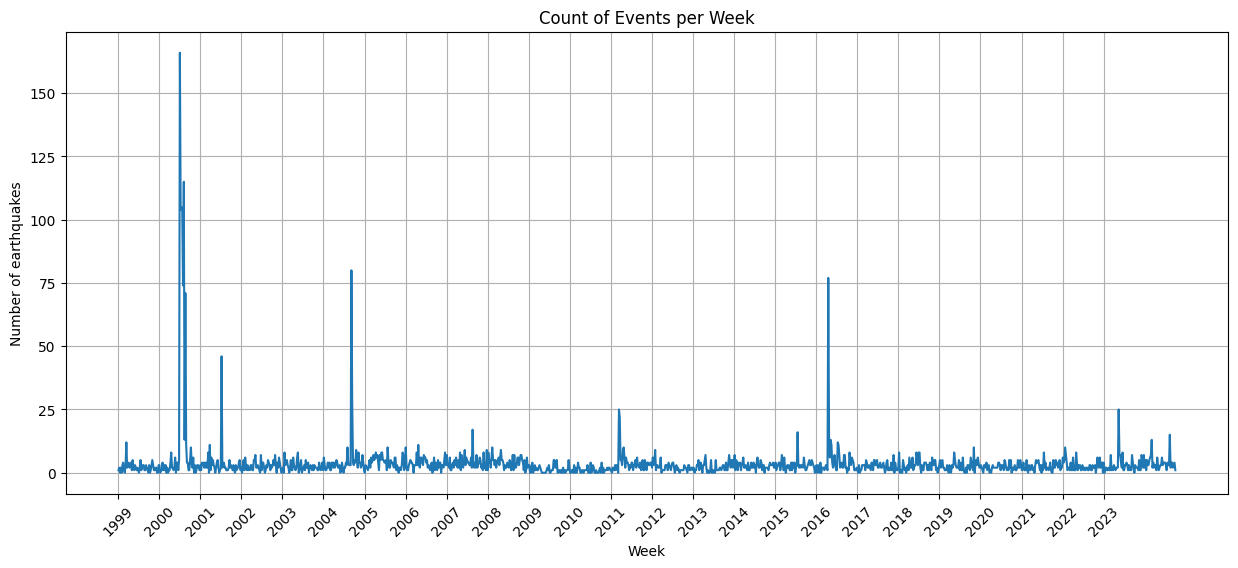

In [136]:
data['time'] = pd.to_datetime(data['time'])

# Group by the week and count the events
df_weekly = data.resample('W-Mon', on='time').size()

# Plot the data
plt.plot(df_weekly.index, df_weekly.values, figure=plt.figure(figsize=(15, 6)))
plt.title('Count of Events per Week')
plt.xlabel('Timeline')
plt.ylabel('Number of earthquakes')
years = pd.date_range(start=data['time'].min(), end=data['time'].max(), freq='YS')
plt.xticks(years, [str(year.year) for year in years], rotation=45)
plt.grid(True)

plt.show()

/var/folders/vw/rm1q12851jq6ww7xsgf4g0x00000gn/T/ipykernel_85768/812424560.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['time'].dt.to_period('M')


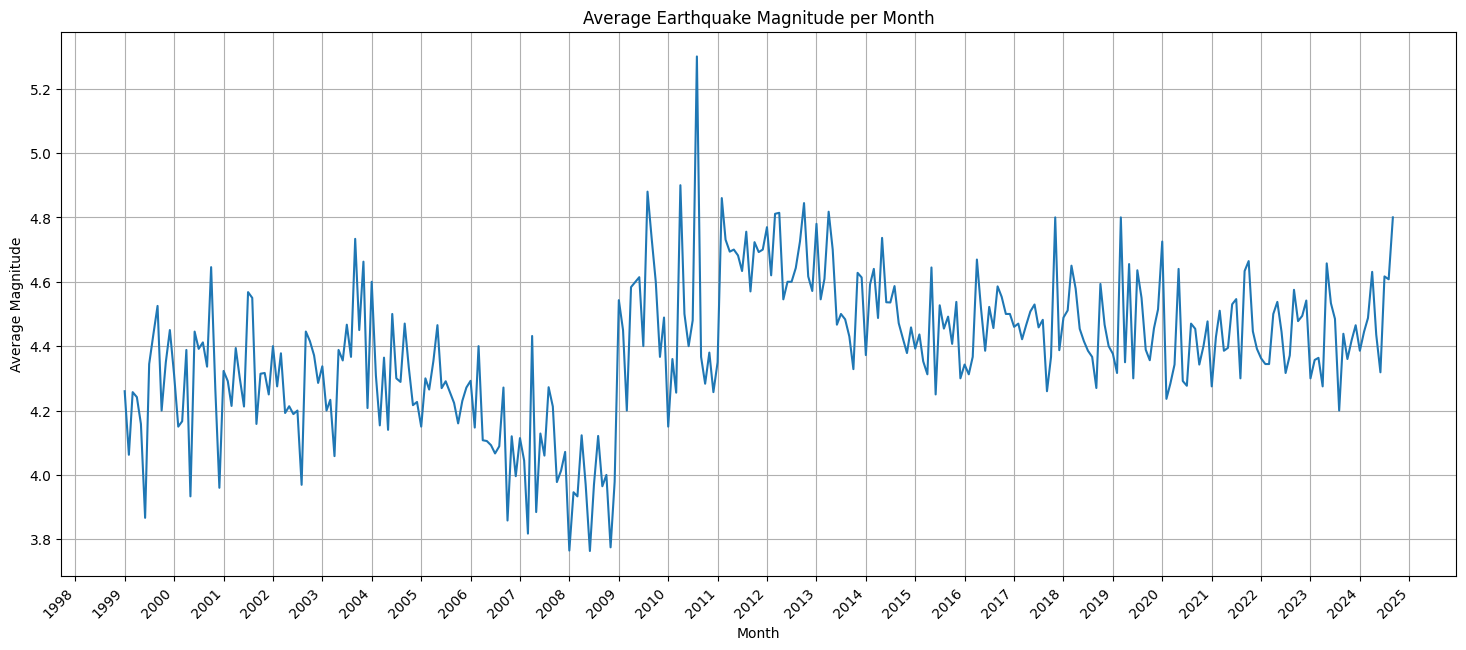

In [141]:
import matplotlib.dates as mdates

# Assuming 'data' is already defined and 'date' column exists
data['year_month'] = data['time'].dt.to_period('M')

# Group by year and month, then calculate the average magnitude
monthly_avg = data.groupby('year_month')['mag'].mean()

# Convert the index from Period to datetime for proper formatting
monthly_avg.index = monthly_avg.index.to_timestamp()

# Plot the data as a line chart
fig, ax = plt.subplots(figsize=(18, 8))
monthly_avg.plot(kind='line', ax=ax)

# Set the title and labels
ax.set_title('Average Earthquake Magnitude per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Average Magnitude')

# Format the x-axis to show ticks for each year
ax.xaxis.set_major_locator(mdates.YearLocator())  # Show ticks per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display years

# Rotate the x-tick labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for readability
plt.grid(True)

# Show the plot
plt.show()
